<a href="https://colab.research.google.com/github/jiuyuanx/Data_Science_Product_Analytics/blob/main/CLTV_Cohort_Estimation/CLTV_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In marketing, customer lifetime value (CLV or often CLTV), lifetime customer value (LCV), or life- time value (LTV) is a prediction of the net profit attributed to the entire future relationship with a customer. Customer lifetime value can also be defined as the dollar value of a customer relationship, based on the present value of the projected future cash flows from the customer relationship. Customer lifetime value is an important concept in that it encourages firms to shift their focus from quarterly profits to the long-term health of their customer relationships. Customer lifetime value is an important number because it represents an upper limit on spending to acquire new customers. For this reason, it is an important element in calculating payback of advertising spent in marketing mix modeling.

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

In [151]:
df = pd.read_csv('/content/drive/MyDrive/Data_Science_Product_Manager/customer_sales.csv')
df

,Order ID,Order Date,Customer Name,Country,State,City,Region,Segment,Ship Mode,Category,Sub-Category,Product Name,Discount,Sales,Profit,Quantity
0,BN-2011-7407039,1/1/11,Ruby Patel,Sweden,Stockholm,Stockholm,North,Home Office,Economy Plus,Office Supplies,Paper,"Enermax Note Cards, Premium",0.5,$45,-26.0,3.0
1,AZ-2011-9050313,1/3/11,Summer Hayward,United Kingdom,England,Southport,North,Consumer,Economy,Furniture,Bookcases,"Dania Corner Shelving, Traditional",0.0,$854,290.0,7.0
2,AZ-2011-6674300,1/4/11,Devin Huddleston,France,Auvergne-Rhône-Alpes,Valence,Central,Consumer,Economy,Office Supplies,Art,"Binney & Smith Sketch Pad, Easy-Erase",0.0,$140,21.0,3.0
3,BN-2011-2819714,1/4/11,Mary Parker,United Kingdom,England,Birmingham,North,Corporate,Economy,Office Supplies,Art,"Boston Markers, Easy-Erase",0.5,$27,-22.0,2.0
4,BN-2011-2819714,1/4/11,Mary Parker,United Kingdom,England,Birmingham,North,Corporate,Economy,Office Supplies,Storage,"Eldon Folders, Single Width",0.5,$17,-1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8042,AZ-2014-766953,12/31/14,Jose Gambino,United Kingdom,England,Maidenhead,North,Corporate,Economy,Furniture,Bookcases,"Ikea Stackable Bookrack, Traditional",0.0,$245,91.0,2.0
8043,BN-2014-4140795,12/31/14,Daniel Hamilton,Netherlands,North Brabant,Eindhoven,Central,Home Office,Economy Plus,Office Supplies,Art,"BIC Pencil Sharpener, Fluorescent",0.5,$30,-10.0,2.0
8044,BN-2014-4140795,12/31/14,Daniel Hamilton,Netherlands,North Brabant,Eindhoven,Central,Home Office,Economy Plus,Office Supplies,Binders,"Avery Binder Covers, Recycled",0.5,$23,-6.0,4.0
8045,BN-2014-4140795,12/31/14,Daniel Hamilton,Netherlands,North Brabant,Eindhoven,Central,Home Office,Economy Plus,Technology,Machines,"StarTech Phone, Red",0.5,$108,-19.0,3.0


## **Explore the dataset**

In [152]:
df.isnull().sum()

Order ID          0
Order Date        6
Customer Name     1
Country           1
State             4
City              4
Region            0
Segment           1
Ship Mode         5
Category          5
Sub-Category      0
Product Name      0
Discount          7
Sales             2
Profit           13
Quantity         13
dtype: int64

In [153]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
print("Range of Dates: ", df['Order Date'].min(), '~', df['Order Date'].max())
print("Percent unique customers: ", round(df['Customer Name'].unique().shape[0]/len(df) * 100,2), "%")
print("Percent unique orders: ", round(df['Order ID'].nunique()/len(df) * 100,2), "%")
print("Percent unique product: ", round(df['Product Name'].nunique()/len(df) * 100,2), "%")
print("Number unique cities: ", df['City'].nunique())


Range of Dates:  2011-01-01 00:00:00 ~ 2014-12-31 00:00:00
Percent unique customers:  9.85 %
Percent unique orders:  51.16 %
Percent unique product:  22.49 %
Number unique cities:  998


In [154]:
df['Sales'] = df['Sales'].replace('[\$,]', '', regex=True)
df['Sales'] = df['Sales'].replace('\((.*?)\)', r'-\1', regex=True)
df['Sales'] = df['Sales'].astype(float)

In [155]:
df.dtypes

Order ID                 object
Order Date       datetime64[ns]
Customer Name            object
Country                  object
State                    object
City                     object
Region                   object
Segment                  object
Ship Mode                object
Category                 object
Sub-Category             object
Product Name             object
Discount                float64
Sales                   float64
Profit                  float64
Quantity                float64
dtype: object

0it [00:00, ?it/s]

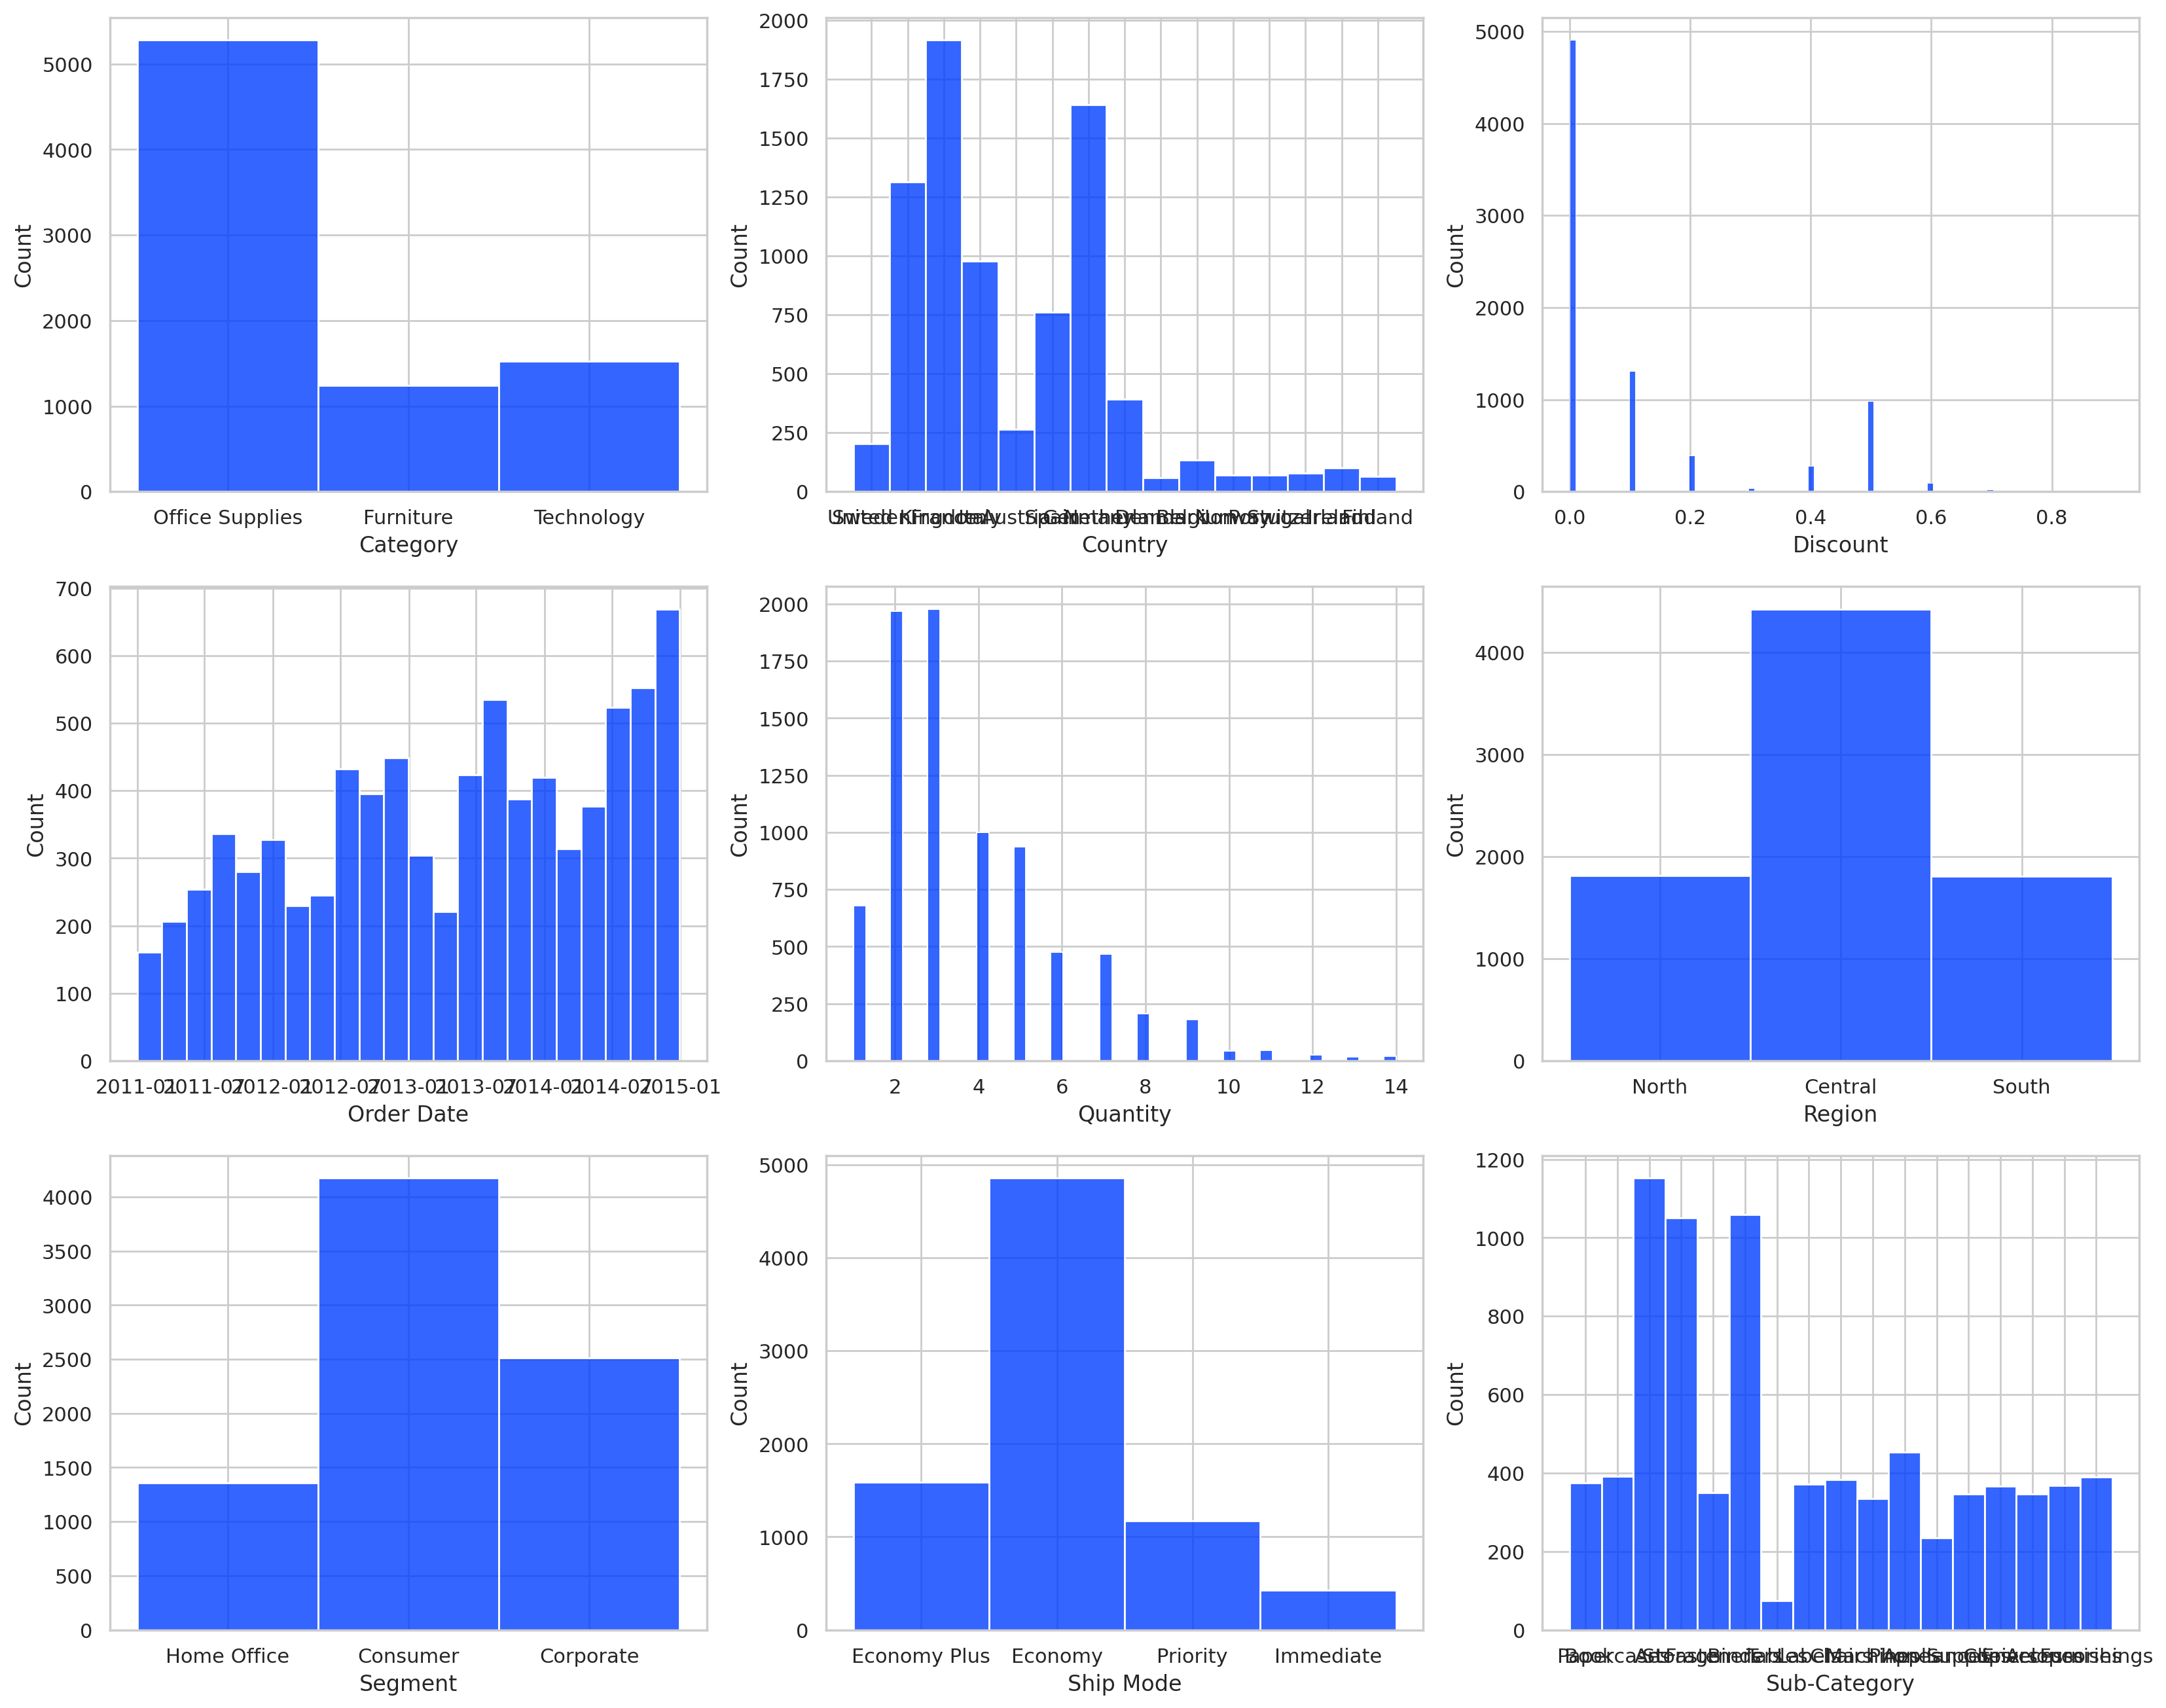

In [156]:
sns.set(style='whitegrid', palette='bright')
fig, ax = plt.subplots(3,3, figsize=(20,16), dpi=200)
ax = ax.ravel()
df_temp = df[df.columns.difference(['Order ID', 'City', 'Customer Name', 'Product Name', 'State', 'Profit', 'Sales'])]

for i, col in tqdm(enumerate(df_temp.columns)):
  sns.histplot(df_temp[col], ax = ax[i], alpha=0.8)

plt.show()

In [157]:
df[['Sales']].sort_values(by=['Sales'])

,Sales
180,-110.0
7327,-70.0
7328,-47.0
381,0.0
2162,3.0
...,...
868,6517.0
28,198000.0
5246,206000.0
557,NaN


In [158]:
# df = df[(df['Sales']<=6517) & (~pd.isna(df['Sales'])) ]

<Axes: xlabel='Sales', ylabel='Density'>

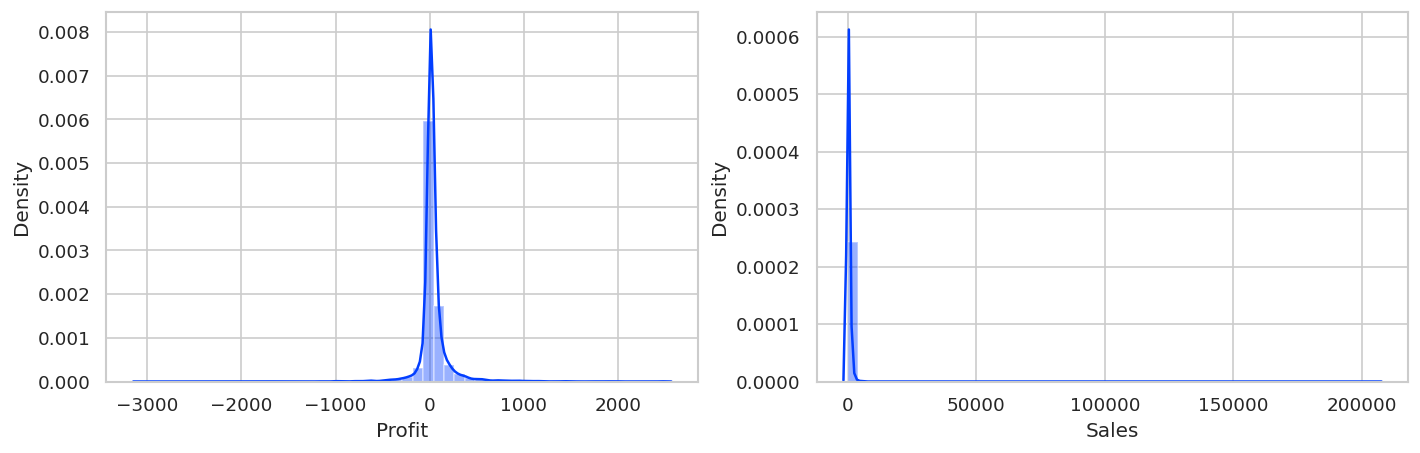

In [159]:
fig, ax = plt.subplots(1,2, figsize=(14,4), dpi=120)
sns.distplot(df['Profit'], ax=ax[0])
sns.distplot(df['Sales'], ax = ax[1])

<Axes: xlabel='Order Date', ylabel='Sales'>

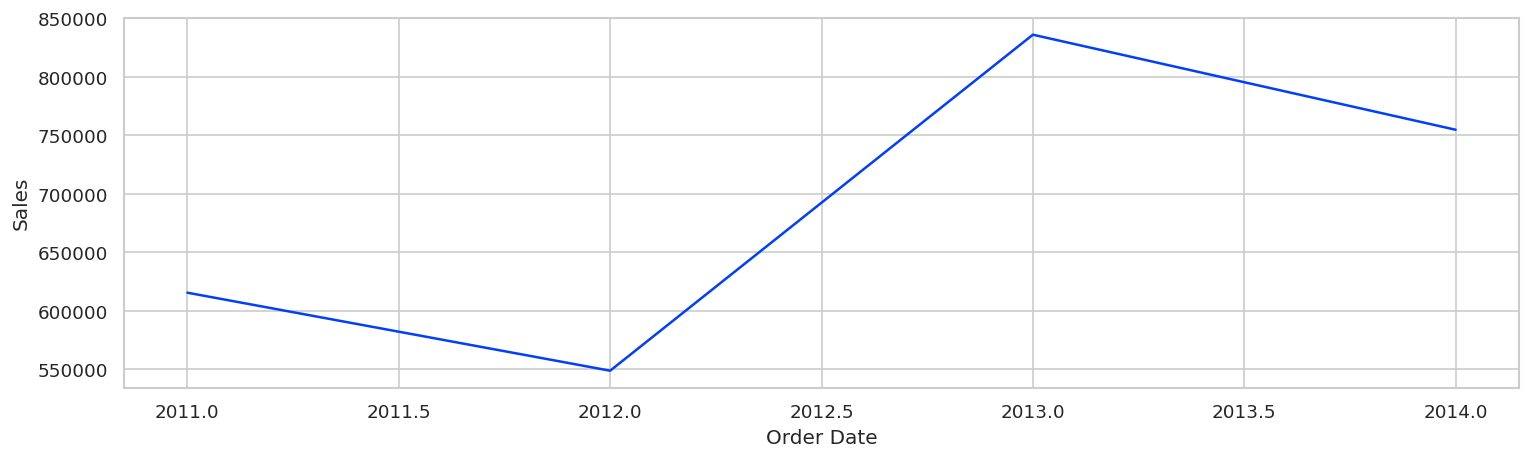

In [160]:
plt.figure(figsize=(15,4), dpi=120)
sns.lineplot(df.groupby(by=[df['Order Date'].dt.year])['Sales'].sum())

In [161]:
df['Discount'].unique()

array([0.5, 0. , 0.1, 0.6, 0.4, 0.2, 0.7, 0.3, nan, 0.8, 0.9])

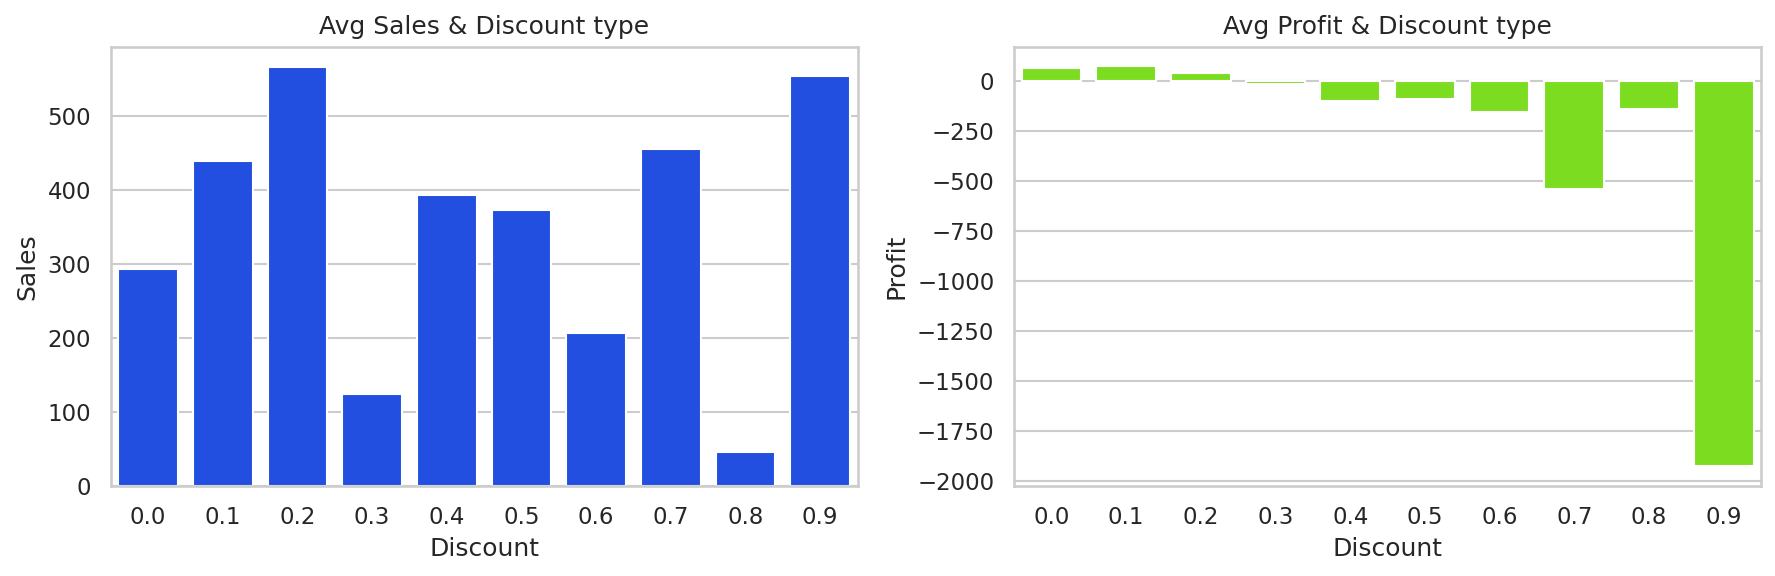

In [162]:
fig, ax = plt.subplots(1,2, figsize=(12, 4), dpi=150)
df_sales = pd.pivot_table(df, values='Sales', index='Discount', aggfunc='mean').reset_index()
sns.barplot(df_sales, x='Discount', y='Sales', ax=ax[0])
ax[0].set_title('Avg Sales & Discount type')


df_profit = pd.pivot_table(df, values='Profit', index='Discount', aggfunc='mean').reset_index()
sns.barplot(df_profit, x='Discount', y='Profit', ax=ax[1], color='lawngreen')
ax[1].set_title('Avg Profit & Discount type')

plt.tight_layout()
plt.show()

In [163]:
df_tot = df_sales.merge(df_profit, on='Discount')
df_tot
display(df_tot)
max_tot_profit = df_tot[['Profit']].idxmax()
df_tot.iloc[max_tot_profit]

,Discount,Sales,Profit
0,0.0,293.139013,63.813137
1,0.1,439.359756,72.719726
2,0.2,566.305556,41.718987
3,0.3,123.800000,-15.875000
4,0.4,393.546099,-97.865248
5,0.5,373.033605,-89.086558
6,0.6,206.760417,-155.718750
7,0.7,455.800000,-537.850000
8,0.8,46.333333,-142.000000
9,0.9,555.000000,-1925.000000


,Discount,Sales,Profit
1,0.1,439.359756,72.719726


## **Determine Customer Acquire Date**

In [164]:
df_customer = df.groupby('Customer Name')['Order Date'].min().rename('Acquisition Year').dt.year.reset_index()
df_customer

,Customer Name,Acquisition Year
0,Aaron Bootman,2011
1,Aaron Cunningham,2011
2,Aaron Davey,2011
3,Aaron Macrossan,2011
4,Abbie Perry,2011
...,...,...
787,Zara Loton,2013
788,Zara Money,2011
789,Zoe Lanigan,2011
790,Zoe Lowin,2011


In [165]:
df = df.merge(df_customer, 'inner', on='Customer Name')
df

,Order ID,Order Date,Customer Name,Country,State,City,Region,Segment,Ship Mode,Category,Sub-Category,Product Name,Discount,Sales,Profit,Quantity,Acquisition Year
0,BN-2011-7407039,2011-01-01,Ruby Patel,Sweden,Stockholm,Stockholm,North,Home Office,Economy Plus,Office Supplies,Paper,"Enermax Note Cards, Premium",0.5,45.0,-26.0,3.0,2011
1,AZ-2011-1335871,2011-06-14,Ruby Patel,United Kingdom,England,London,North,Home Office,Economy,Office Supplies,Storage,"Tenex File Cart, Industrial",0.1,241.0,24.0,2.0,2011
2,AZ-2012-6683296,2012-04-27,Ruby Patel,Germany,Lower Saxony,Hanover,Central,Home Office,Priority,Office Supplies,Storage,"Eldon Trays, Industrial",0.6,39.0,-13.0,2.0,2011
3,AZ-2012-6683296,2012-04-27,Ruby Patel,Germany,Lower Saxony,Hanover,Central,Home Office,Priority,Office Supplies,Supplies,"Elite Scissors, High Speed",0.5,34.0,-1.0,3.0,2011
4,AZ-2012-2626732,2012-08-30,Ruby Patel,Germany,North Rhine-Westphalia,Bottrop,Central,Home Office,Economy,Office Supplies,Fasteners,"Advantus Paper Clips, Assorted Sizes",0.0,153.0,70.0,11.0,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,AZ-2014-8014717,2014-09-16,Carol Leach,United Kingdom,England,Chelmsford,North,Home Office,Economy,Technology,Accessories,"Logitech Router, Erganomic",0.0,1716.0,309.0,7.0,2014
8042,AZ-2014-5759981,2014-11-15,Carol Leach,France,Normandy,Le Havre,Central,Home Office,Economy,Office Supplies,Art,"Stanley Markers, Fluorescent",0.0,47.0,16.0,2.0,2014
8043,AZ-2014-1127335,2014-10-20,Charles Rice,Germany,Hamburg,Hamburg,Central,Corporate,Priority,Office Supplies,Storage,"Smead Shelving, Blue",0.1,396.0,88.0,9.0,2014
8044,AZ-2014-1127335,2014-10-20,Charles Rice,Germany,Hamburg,Hamburg,Central,Corporate,Priority,Office Supplies,Supplies,"Fiskars Shears, Easy Grip",0.0,246.0,25.0,5.0,2014


## **Calculate cumulative transaction amounts**

In [166]:
#Customer Yearly Value
df = df.dropna()
years = [2011,2012,2013,2014]

ages = [1,2,3,4]
yearly_sales = []
for yr in years:
  customer = df[df['Acquisition Year']==yr]
  sales = []
  for i, age in enumerate(ages):
    s = customer[customer['Order Date'].dt.year == yr+i]['Sales'].sum()
    sales.append(s)

  yearly_sales.append([yr, *sales])
yearly_sales = pd.DataFrame(yearly_sales, columns = ['Acquire Year',12, 24, 36, 48])
yearly_sales

,Acquire Year,12,24,36,48
0,2011,607413.0,335925.0,376906.0,482026.0
1,2012,212955.0,169485.0,195370.0,0.0
2,2013,289627.0,65292.0,0.0,0.0
3,2014,12108.0,0.0,0.0,0.0


In [167]:
#Customer Lifetime Value
years = [2011,2012,2013,2014]

ages = [1,2,3,4]
total_sales = []
for yr in years:
  customer = df[df['Acquisition Year']==yr]
  sales = []
  for i, age in enumerate(ages):
    s = customer[customer['Order Date'].dt.year <= yr+i]['Sales'].sum()
    sales.append(s)

  total_sales.append([yr, *sales])
total_sales = pd.DataFrame(total_sales, columns = ['Acquire Year',12, 24, 36, 48])
total_sales

,Acquire Year,12,24,36,48
0,2011,607413.0,943338.0,1320244.0,1802270.0
1,2012,212955.0,382440.0,577810.0,577810.0
2,2013,289627.0,354919.0,354919.0,354919.0
3,2014,12108.0,12108.0,12108.0,12108.0


## **Calculate the number of new customers**

In [168]:
new_customers = []
for yr in years:
  customer = df[df['Acquisition Year']==yr]
  new_customer = []
  for i, age in enumerate(ages):
    s = customer['Customer Name'].nunique()
    if yr+age<=2015:
      new_customer.append(s)
    else:
      new_customer.append(0)
  new_customers.append([yr, *new_customer])
new_customers = pd.DataFrame(new_customers, columns = ['Acquire Year',12, 24, 36, 48])
new_customers

,Acquire Year,12,24,36,48
0,2011,492,492,492,492
1,2012,204,204,204,0
2,2013,79,79,0,0
3,2014,17,0,0,0


## **Historic CLV**

In [169]:
cv = (yearly_sales[[12, 24, 36, 48]]/new_customers[[12, 24, 36, 48]])
cv

,12,24,36,48
0,1234.579268,682.774390,766.069106,979.727642
1,1043.897059,830.808824,957.696078,NaN
2,3666.164557,826.481013,NaN,NaN
3,712.235294,NaN,NaN,NaN


In [170]:
clv = (total_sales[[12, 24, 36, 48]]/new_customers[[12, 24, 36, 48]])
clv

,12,24,36,48
0,1234.579268,1917.353659,2683.422764,3663.150407
1,1043.897059,1874.705882,2832.401961,inf
2,3666.164557,4492.645570,inf,inf
3,712.235294,inf,inf,inf


Text(0.5, 1.0, 'CLTV in times & different cohorts by acquisition year')

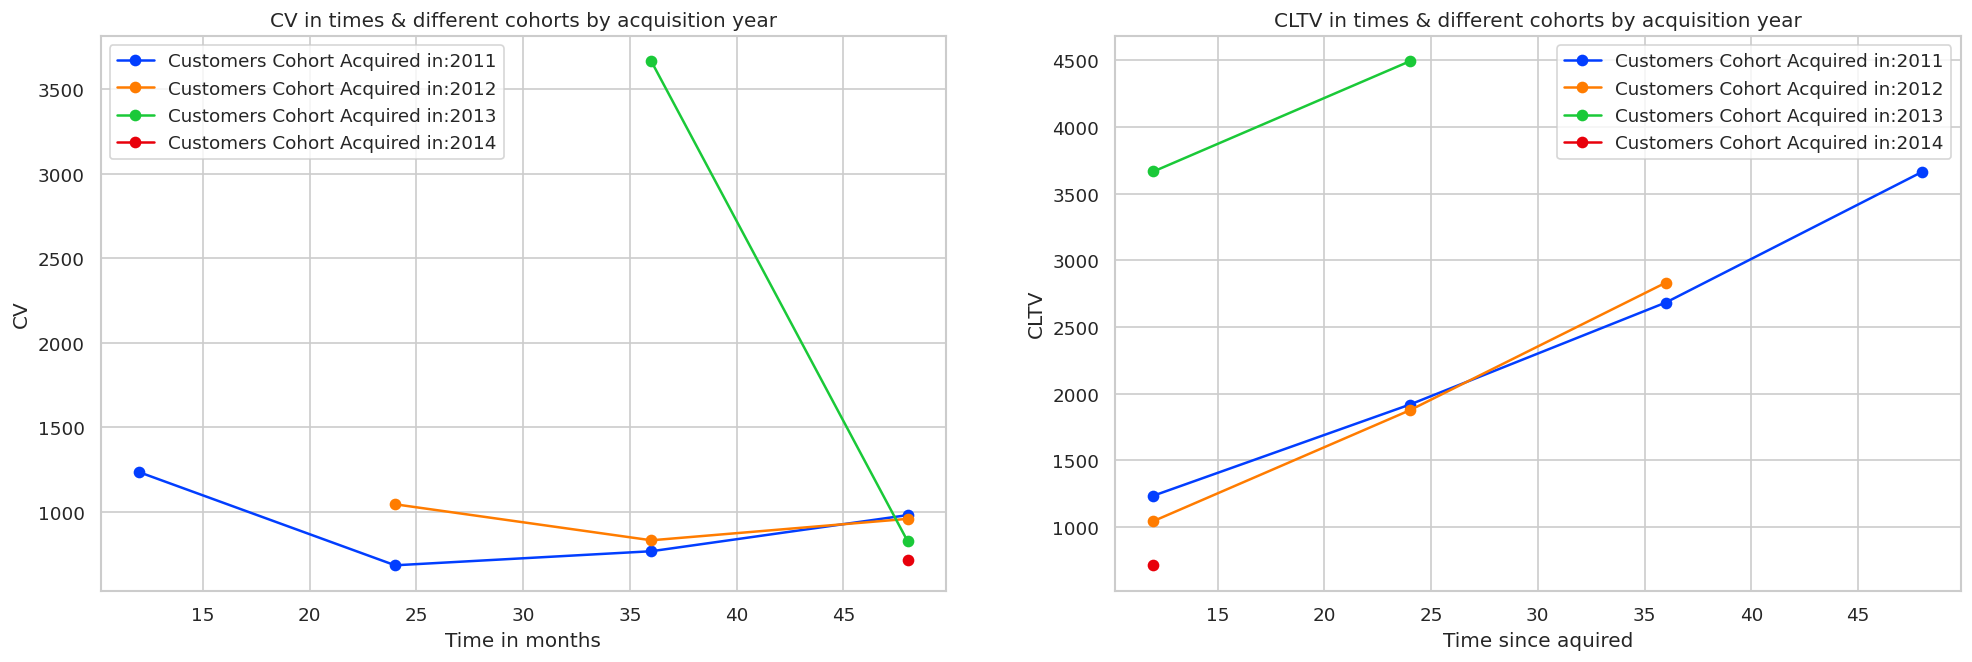

In [176]:
ages = [12, 24, 36, 48]
fig, ax = plt.subplots(1,2, figsize = (20,6), dpi=120)
for i in range(len(cv)):
  ts = cv.iloc[i].dropna()
  ax[0].plot(ages[i:], ts, label = "Customers Cohort Acquired in:"+str(years[i]),marker='o')
ax[0].legend()
ax[0].set_xlabel('Time in months')
ax[0].set_ylabel('CV')
ax[0].set_title('CV in times & different cohorts by acquisition year')


for i in range(len(clv)):
  ts = clv.iloc[i]
  ax[1].plot(ts, label = "Customers Cohort Acquired in:"+str(years[i]),marker='o')
ax[1].legend()
ax[1].set_xlabel('Time since aquired')
ax[1].set_ylabel('CLTV')
ax[1].set_title('CLTV in times & different cohorts by acquisition year')
